<a href="https://colab.research.google.com/github/parshikondagarla-sketch/clv-prediction/blob/main/Untitled13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Cell 1: Header + install (Colab friendly)
# Project: Customer Lifetime Value (CLV) Prediction
# Author: Kondagurla Parshi

# Install xgboost if not present (Colab)
try:
    import xgboost
except Exception:
    !pip install xgboost -q


In [2]:
# Cell 2: imports & create folders
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler

try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

# Create folder to save images and outputs in the Colab runtime
os.makedirs("reports/figures", exist_ok=True)


In [5]:
from google.colab import files
uploaded = files.upload()


Saving OnlineRetail.csv.zip to OnlineRetail.csv.zip


In [8]:
import pandas as pd
df = pd.read_csv("OnlineRetail.csv.zip", encoding='unicode_escape')
print("Shape:", df.shape)


Shape: (541909, 8)


In [9]:
# Cell 4: Cleaning and RFM feature engineering

# Select only the relevant columns
cols = ['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']
df = df[[c for c in cols if c in df.columns]]

# Drop rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)

# Remove cancelled orders or negative quantities
df = df[df['Quantity'] > 0]

# Convert InvoiceDate to datetime and calculate TotalPrice
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Reference date (1 day after the last invoice)
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# Group by CustomerID to create RFM features
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                               # Frequency
    'TotalPrice': 'sum',                                  # Monetary
    'Quantity': 'sum'                                     # Total quantity
}).reset_index().rename(columns={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'TotalPrice':'Monetary',
    'Quantity':'TotalQty'
})

# Create additional useful features
rfm['AvgOrderValue'] = rfm['Monetary'] / rfm['Frequency']
rfm['AvgQtyPerOrder'] = rfm['TotalQty'] / rfm['Frequency']

# Replace infinities or NaNs with zeros
rfm = rfm.replace([np.inf, -np.inf], np.nan).fillna(0)

print("RFM dataset created successfully!")
print("Shape:", rfm.shape)
rfm.head()


RFM dataset created successfully!
Shape: (4339, 7)


,CustomerID,Recency,Frequency,Monetary,TotalQty,AvgOrderValue,AvgQtyPerOrder
0,12346,326,1,77183.60,74215,77183.600000,74215.000000
1,12347,2,7,4310.00,2458,615.714286,351.142857
2,12348,75,4,1797.24,2341,449.310000,585.250000
3,12349,19,1,1757.55,631,1757.550000,631.000000
4,12350,310,1,334.40,197,334.400000,197.000000


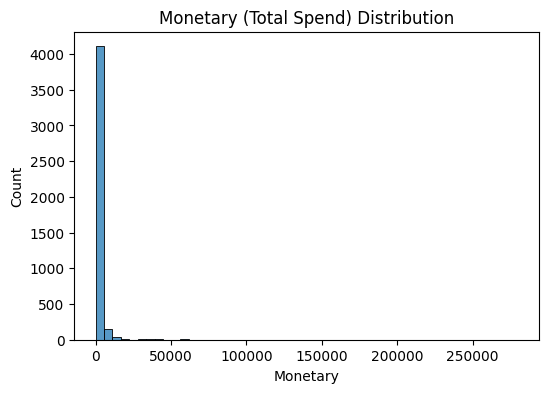

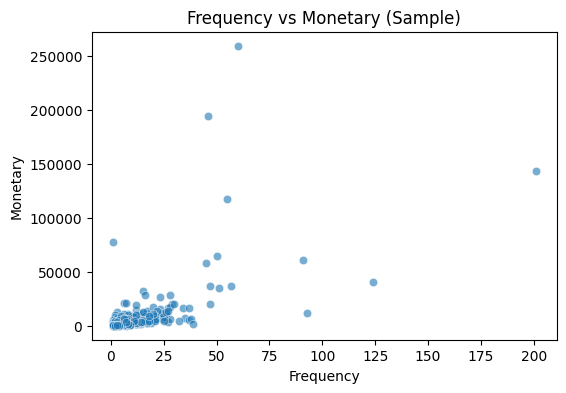

In [10]:
# Cell 5: EDA visuals
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.histplot(rfm['Monetary'], bins=50)
plt.title('Monetary (Total Spend) Distribution')
plt.show()

plt.figure(figsize=(6,4))
sample = rfm.sample(2000, random_state=42)
sns.scatterplot(data=sample, x='Frequency', y='Monetary', alpha=0.6)
plt.title('Frequency vs Monetary (Sample)')
plt.show()


In [11]:
# Cell 6: Prepare features for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select features and target
features = ['Recency','Frequency','AvgOrderValue','AvgQtyPerOrder']
X = rfm[features]
y = rfm['Monetary']

# Log-transform target (to handle skewed values)
y_log = np.log1p(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Train/Test split complete!")
print("Train shape:", X_train.shape, "| Test shape:", X_test.shape)


Train/Test split complete!
Train shape: (3471, 4) | Test shape: (868, 4)


In [13]:
# Cell 7 (fixed): Train models and evaluate (compatible across sklearn versions)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

try:
    from xgboost import XGBRegressor
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False

results = {}

def evaluate_model(name, model, X_tr, X_te, y_tr, y_te):
    # Train
    model.fit(X_tr, y_tr)
    # Predict (log scale)
    preds_log = model.predict(X_te)
    # Convert back to original monetary scale
    y_true = np.expm1(y_te)
    y_pred = np.expm1(preds_log)
    # Metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mse ** 0.5
    results[name] = {'R2': r2, 'MAE': mae, 'RMSE': rmse}
    print(f"{name} → R²: {r2:.4f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")
    return model

# Train models
lr = evaluate_model("Linear Regression", LinearRegression(), X_train_scaled, X_test_scaled, y_train, y_test)
rf = evaluate_model("Random Forest", RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1),
                    X_train, X_test, y_train, y_test)

if XGBOOST_AVAILABLE:
    xgb = evaluate_model("XGBoost", XGBRegressor(n_estimators=150, learning_rate=0.05, random_state=42, n_jobs=-1),
                         X_train, X_test, y_train, y_test)
else:
    print("⚠️ XGBoost not available in this session.")


Linear Regression → R²: -1784.5024, MAE: 15437.38, RMSE: 393110.54
Random Forest → R²: 0.8086, MAE: 249.49, RMSE: 4070.17
XGBoost → R²: 0.9638, MAE: 177.62, RMSE: 1770.90


In [15]:
# Cell 8: Cross-validation for RandomForest (to check stability)
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_model = RandomForestRegressor(n_estimators=150, random_state=42, n_jobs=-1)

cv_scores = cross_val_score(cv_model, X, y_log, cv=kf, scoring='r2', n_jobs=-1)

print("✅ RandomForest 5-Fold CV R² scores:", np.round(cv_scores, 3))
print("Average CV R²:", np.round(cv_scores.mean(), 3))


✅ RandomForest 5-Fold CV R² scores: [0.997 0.994 0.994 0.996 0.996]
Average CV R²: 0.996


Best model: XGBoost


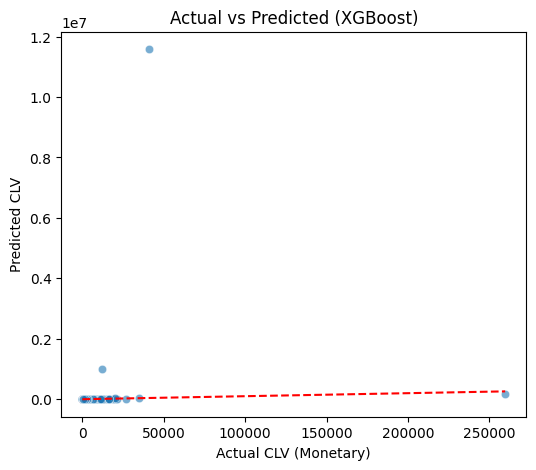

In [14]:
# Cell 8: Visualize actual vs predicted and feature importance
import matplotlib.pyplot as plt
import seaborn as sns

best_model = max(results.items(), key=lambda x: x[1]['R2'])[0]
print("Best model:", best_model)

final_model = rf if best_model == "Random Forest" else lr

y_pred = np.expm1(final_model.predict(X_test if best_model == "Random Forest" else X_test_scaled))
y_true = np.expm1(y_test)

plt.figure(figsize=(6,5))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.title(f"Actual vs Predicted ({best_model})")
plt.xlabel("Actual CLV (Monetary)")
plt.ylabel("Predicted CLV")
plt.show()


🏆 Best model: XGBoost


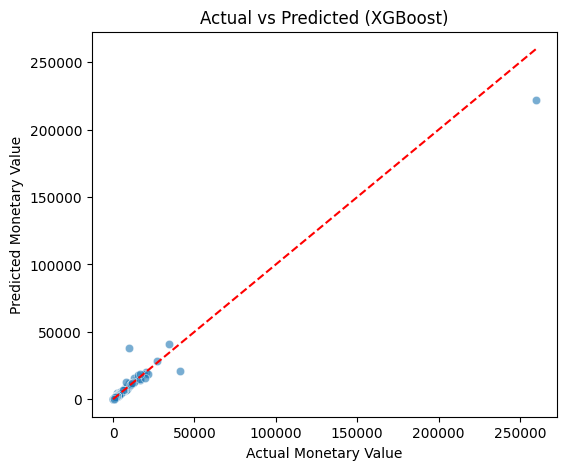

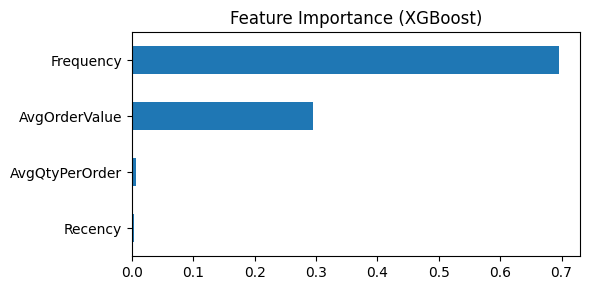

📁 Top 10 customers saved to reports/top_customers.csv


,CustomerID,Recency,Frequency,Monetary,TotalQty,AvgOrderValue,AvgQtyPerOrder,PredictedMonetary
1690,14646,2,74,280206.02,197491,3786.567838,2668.797297,272272.562500
4202,18102,1,60,259657.30,64124,4327.621667,1068.733333,222335.828125
3729,17450,8,46,194550.79,69993,4229.365000,1521.586957,181978.703125
3009,16446,1,2,168472.50,80997,84236.250000,40498.500000,148750.343750
1880,14911,1,201,143825.06,80515,715.547562,400.572139,134891.046875
55,12415,24,21,124914.53,77670,5948.310952,3698.571429,121464.210938
1334,14156,10,55,117379.63,57885,2134.175091,1052.454545,112474.453125
3772,17511,3,31,91062.38,64549,2937.496129,2082.225806,88283.007812
2703,16029,39,63,81024.84,40208,1286.108571,638.222222,77835.320312
3177,16684,4,28,66653.56,50255,2380.484286,1794.821429,69533.882812


In [16]:
# Cell 9: Analyze best model, visualize predictions, and extract insights
import matplotlib.pyplot as plt
import seaborn as sns

# Identify best model based on highest R²
best_model_name = max(results.items(), key=lambda x: x[1]['R2'])[0]
print("🏆 Best model:", best_model_name)

# Map names to model objects
model_map = {
    "Linear Regression": lr,
    "Random Forest": rf
}
if XGBOOST_AVAILABLE:
    model_map["XGBoost"] = xgb

final_model = model_map.get(best_model_name, rf)

# Pick correct features (scaled for Linear Regression)
Xp_test = X_test_scaled if best_model_name == "Linear Regression" else X_test

# Predict on test data (convert back from log scale)
y_pred = np.expm1(final_model.predict(Xp_test))
y_true = np.expm1(y_test)

# 1️⃣ Actual vs Predicted plot
plt.figure(figsize=(6,5))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual Monetary Value")
plt.ylabel("Predicted Monetary Value")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.show()

# 2️⃣ Feature importance (for tree-based models)
if hasattr(final_model, "feature_importances_"):
    fi = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=True)
    plt.figure(figsize=(6,3))
    fi.plot(kind='barh')
    plt.title(f"Feature Importance ({best_model_name})")
    plt.tight_layout()
    plt.show()
else:
    print("No feature importance attribute available for this model.")

# 3️⃣ Predict for all customers and save top 10 by predicted CLV
Xp_all = X if best_model_name != "Linear Regression" else scaler.transform(X)
pred_log_all = final_model.predict(Xp_all)
rfm['PredictedMonetary'] = np.expm1(pred_log_all)

top_customers = rfm.sort_values('PredictedMonetary', ascending=False).head(10)
top_customers.to_csv("reports/top_customers.csv", index=False)
print("📁 Top 10 customers saved to reports/top_customers.csv")

top_customers
